# Lab 4 - Multi-class Classification (linear vs nonlinear approach) 

## PART 1: One-vs-all multi-class classification with Logistic Regression - linear approach
Objectives: Implementation of one-vs-all Logistic Regression (linear approach) to recognize hand-written digits (from 0 to 9) from images. 

**Problem**: Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This assignment will show you how the methods you've learned can be used for this classification task. In this part, you will extend your previous implementation of Logistic Regression and apply it to one-vs-all classification.

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat

### Load Data

File *ex3data1.mat* contains 5000 training examples of handwritten digits. This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/). The .mat format means that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. 

Use function *loadmat* to load the data as a dictionary with keys X and y (training data). 

There are 5000 training examples, each example is a 20x20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20x20 grid of pixels is unrolled into a 400-dimensional vector. Each of these training examples becomes a single row in the array X. This gives a (5000, 400) shape X, where on every row are the pixels of one image.

y is a (5000, 1) shape vector of the training set labels. 
Data was initially processed with MATLAB where there is no zero index, therefore the digit 0 is mapped to the value 10. Thus, a 0 digit is labeled as 10, while the digits 1 to 9 are labeled as 1 to 9 in their natural order.

In [2]:
mat=loadmat("ex3data1.mat")

# mat is a dict with key "X" for x-values, and key "y" for y values
X=mat["X"]
y=mat["y"]

#number of training examples
m=5000
print(y[4000:4010])

[[8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]]


### Plot subset of data

The code below randomly selects 100 rows from X, maps each row to a 20x20 pixel grayscale image and displays the images together, you should see an image like in Fig. 1.

<img src="images/f1.png" style="width:350px;height:250px;">
<caption><center> **Fig. 1** : **Examples from MNIST handwritten digit dataset** </center></caption>

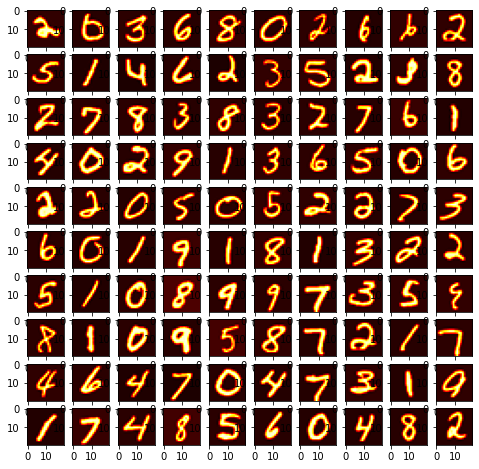

In [3]:
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
                                                        #reshape back to 20x20 pixel image
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") 


### Computing the Cost Function

Recall that the regularized cost function in logistic regression is:

$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

The cost gradients are (remember that the gradient of $\theta_0$ is not regularized): 

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j$ for $j\geq 1$

In [4]:
# Add sigmoid FUNCTION from the previous lab
import numpy as np

def sigmoid(x):
    s= 1/(1+np.exp(-x))
    
    return s


In [59]:
# Add costFunctionReg FUNCTION from the previous lab (the function that computes the regularized cost and the gradients)
import numpy as np

def costFunctionReg(X, y,theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m= len(X)
        
    #vector of the model predictions for all training examples      
    
    h = sigmoid(np.dot(X, theta))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function L2 norm
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

### Test for correct implementation of costFunctionReg

In [52]:
#test with generated data

theta_t = np.array([-2,-1,1,2]).reshape(4,1)

X_t =np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t= np.append(np.ones((5,1)),X_t,axis=1)

y_t = np.array([1,0,1,0,1]).reshape(5,1)

cost, grad = costFunctionReg(X_t, y_t,theta_t, 3)

    
print("Cost:",round(cost,3))        #ANSWER: Cost: 2.535
print("\n Gradients:\n",grad,"\n \n Expected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")


Cost: 2.535

 Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
 
 Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


In [53]:
# Add gradientDescent FUNCTION from the previous lab (the function that returns the optimal theta vector and J_history)
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X, y, theta, Lambda)
        
        #update theta
        theta = theta - alpha * grad
        
        J_history.append(cost)
    
    return theta , J_history

### One-vs-all Classification

You will implement one-vs-all classification by training multiple Regularized Logistic Regression classifiers, one for each of the K classes in the MNIST dataset. 

In the handwritten digits dataset, K = 10, but your code should work for any value of K. You should complete the code in function *oneVsAll* to train one classier for each class. 

Your code should return all the classifier parameters in a Kx(n+1) matrix *all_theta*, where each row corresponds to the learned Logistic Regression parameters for one class. You can do this with a for-loop from 1 to K, training each classifier independently.

Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped the digit “0" to the label 10. When training the classifier for class i you will transform  vector y, with shape (m, 1), in a binary vector, where only for examples with label i, y gets value = 1, and for all other labels (not class i), y gets value = 0. 

Logical arrays are helpful for this task, e.g. y=np.where(y==i,1,0). 


In [62]:
def oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, K):
    """
    Inputs:
    numpy array of data X and labels y
    initial_theta - inicialized vector of model parameters theta 
    alpha - learning rate
    num_iters - number of iterations
    Lambda - regularization parameter 
    K -number of classes
    
    ONEVSALL trains K Logistic Regression classifiers using gradient descent. 
    
    Returns:   
    all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    
    """
    all_theta = []
    all_J=[]
    
    #number of training examples
    m=5000
    
    #number of features
    n=400
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((5000,1)),X,axis=1)
    
    
    for i in range(1,K+1):
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),initial_theta,alpha,num_iters,Lambda)
        
        # sdd the vector of optimized parameters theta of classifier i
        all_theta.extend(theta)
                
        # add the cost function history of classifier i
        all_J.extend(J_history)
        
    return np.array(all_theta).reshape(K,n+1), all_J

In [63]:
#Inicialize vector theta =0
initial_theta = np.zeros((401, 1))

#Optimization hyper-parameters 
alpha=1 #learning rate
num_iters=300
Lambda=0.1

all_theta, all_J = oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, 10)

### Plot the Cost functions for all (K =10) classifiers 

Text(0.5, 1.0, 'Cost function using Gradient Descent')

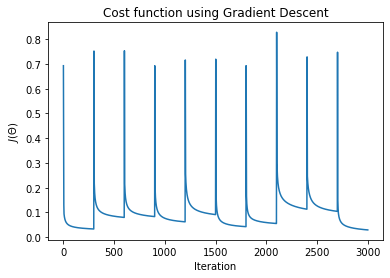

In [64]:
plt.plot(all_J)  #All classifiers
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

### One-vs-all Prediction

After training the one-vs-all classier, you can now use it to predict the digit contained in a given image. 

For each input, you should compute the probability that it belongs to each class using the trained logistic regression classifiers.
The  *predictOneVsAll* function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or K) as the assigned class for this example.
Complete the code in *predictOneVsAll* use the trained (one-vs-all) classifiers to make predictions. You should see that the training set accuracy is about 91.5%. 


In [68]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m=5000
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((5000,1)),X,axis=1)
    
    predictions = np.dot (X, all_theta.T) # predictions.shape =(5000,10)  X(5000x401) * all_theta(401x10) = 5000x10
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)+1

In [70]:
pred = predictOneVsAll(all_theta, X)

#Check that pred.shape  = (5000,) => rank 1 array. You need to reshape it !!!
pred= pred.reshape(5000,1)

# Expected Training Set Accuracy: 91.46 %

print("Training Set Accuracy:",sum(pred==y)[0]/m*100,"%")

Training Set Accuracy: 91.46 %


##  PART 2: One-vs-all multi-class classification with pretrained Neural Network - nonlinear classification

In Part 1, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot propose more complex hypotheses as it is only a linear classifier. 

In this part, you will implement a NN to recognize handwritten digits using the same training set as before. The NN is able to represent complex non-linear hypotheses (models). 

For this assignment, you will use parameters from a NN that have been already trained. Your goal is to use the learned NN parameters (weights) for prediction. 

### Load trained parameters theta (transfer learning)

In [ ]:
mat2=loadmat("ex3weights.mat")
Theta1=mat2["Theta1"] # Theta1 has size 25 x 401
Theta2=mat2["Theta2"] # Theta2 has size 10 x 26

print(Theta1.shape)

print(Theta2.shape)

### Class prediction with trained NN with one hidden layer (feedforward propagation)

Complete the code in function *predict* to return the NN's prediction. You should implement the feedforward computation that computes the NN output for all examples in a vectorized way. Similar to the one-vs-all classification strategy, the NN prediction is the index of the largest output.

You should see that the accuracy is about 97.5%. 

In [ ]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    
    #number of training examples
    m=?
        
    # add an extra column of 1´s corresponding to xo=1
    X = ?
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, Theta1.T)  #Inputs to the hidden layer neurons
    a1=sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, Theta2.T) #Inputs to the output layer neurons
    a2=sigmoid(z2)  #Outputs  of the output layer neurons
    
    return np.argmax(a2,axis=1)+1

In [ ]:
pred2 = predict(Theta1, Theta2, X)

np.shape(pred2)

print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/m*100,"%")

### PART 3: Neural Network training to predict the digit

**Objectives**: Implement Backpropagation algorithm for NN training to the task of hand-written digit recognition.

In this part the code is complete, you just need to understand it. 

**NN cost function:** 
$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j,k}^{(2)})^2]$

*nnCostFunction* computes the NN cost (above) and the gradients with and without regularization.

In [ ]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [ ]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

### Random initialization

Select values for $\theta^{(l)}$ uniformly in the range $[-\epsilon_{init} , \epsilon_{init}]$

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network

$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$

In [ ]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [ ]:
print(25*401+26*10)

In [ ]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())



### Gradient Descent for shallow NN (input-layer => ONE hidden layer => output layer) 

In [ ]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [ ]:
#It may take very long to finish the training. 
#For 1000 iterations the Training Set Accuracy: 95.28(lambda=0.1; alpha=1)
#You may need more iterations (e.g. 1500) to get better accuracy

input_layer_size  = 400
hidden_layer_size = 25

alpha=1 #learning rate
num_iters=1000
Lambda=0.1
num_labels = 10

nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [ ]:
pred3 = predict(Theta1, Theta2, X)

print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y)[0]/m*100,"%")

In [ ]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")